## Community analysis

- File name: analyse_community.py
- Author: Loïc Fischer
- Date created: 05/12/2022
- Date last modified: 23/11/2022
- Python Version: 3.9.13

**This file analyze the different communities and tries to give them a political orientation from the allside database**


In [2]:
## Import Libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import plotly.graph_objects as go
import plotly.express as px

import os
import sys
import json

## Show more than one display per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
## Read the data

PATH                = 'D:/Ada/'
DATA_CHANNEL        = 'df_channels_en.tsv.gz'
DATA_VIDEO_META     = 'yt_metadata_en.jsonl.gz'
DATA_COMMENT        = 'youtube_comments.tsv.gz'
NUM_COMMENT         = 'num_comments.tsv.gz'
COMPRESSION         = 'gzip'
SEPARATOR           = '\t'

df_channels   = pd.DataFrame()
df_video_meta = pd.DataFrame()
df_comments   = pd.DataFrame()

# Read data from memory and clean it
df_channels = pd.read_csv(os.path.join(PATH,DATA_CHANNEL), compression=COMPRESSION,sep=SEPARATOR)
df_channels = df_channels.dropna()

# Read data from memory and clean it
df_video_meta = pd.read_json(os.path.join(PATH,DATA_VIDEO_META), compression=COMPRESSION,lines=True, nrows=10000)
df_video_meta = df_video_meta.dropna()

# Read data from memory and clean it
df_comments = pd.read_csv(os.path.join(PATH,DATA_COMMENT),sep=SEPARATOR,nrows=1e6)
df_comments = df_comments.dropna()

# Display of the imported datasets
df_video_meta.head(2)
df_channels.head(2)
df_comments.head(2)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.270363,Lego City Police Lego Firetruck Cartoons about...,1.0,SBqSc91Hn9g,1159,8.0,"lego city,lego police,lego city police,lego ci...",Lego City Police Lego Firetruck Cartoons about...,2016-09-28 00:00:00,1057
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.914516,Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,1.0,UuugEl86ESY,2681,23.0,"Lego superheroes,lego hulk,hulk smash,lego mar...",Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,2016-09-28 00:00:00,12894


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087


,author,video_id,likes,replies
0,1,Gkb1QMHrGvA,2,0
1,1,CNtp0xqoods,0,0


In [4]:
## Creating dataframe with only news and politics channels
news_channels=pd.DataFrame()
news_channels=df_channels[df_channels['category_cc']=='News & Politics']

## Cleaning
news_channels=news_channels.drop(['join_date','subscriber_rank_sb','weights'],axis=1)

## Dataframe with channel id and community
df_channels_id=pd.DataFrame()
df_channels_id = pd.read_csv('data/channels.csv',sep=';')

## Merging on channel id
news_channels = pd.merge(left=df_channels_id, right=news_channels, left_on='channel_id', right_on='channel')
news_channels=news_channels.drop(['channel'],axis=1)

news_channels.head()

,channel_num,channel_id,category_cc,name_cc,subscribers_cc,videos_cc
0,0,UCttspZesZIDEwwpVIgoZtWQ,News & Politics,IndiaTV,15177282,139814
1,1,UCRWFSbif-RFENbBrSiez1DA,News & Politics,ABP NEWS,16274836,129027
2,2,UCmphdqZNmqL72WJ2uyiNw5w,News & Politics,ABP NEWS HINDI,10800000,51298
3,3,UCx8Z14PpntdaxCt2hakbQLQ,News & Politics,The Lallantop,9120000,9423
4,4,UCIvaYmXn910QMdemBG3v1pQ,News & Politics,Zee News,9280000,102648


In [5]:
## Reading communities
communities=pd.read_csv("csv_outputs/louvain_communities_channels_large.csv",sep=";")
communities.head()

## Merging ang cleaning
news_channels_com = pd.merge(left=news_channels, right=communities, left_on='channel_num', right_on='channel',suffixes=('', ''))
news_channels_com = news_channels_com.drop(['channel'],axis=1)
news_channels_com.head()

,channel,community
0,2049,0
1,1028,0
2,6,0
3,7,0
4,9,0


,channel_num,channel_id,category_cc,name_cc,subscribers_cc,videos_cc,community
0,6,UCupvZG-5ko_eiXAupbDfxWw,News & Politics,CNN,7500000,146299,0
1,7,UCfwx98Wty7LhdlkxL5PZyLA,News & Politics,Barcroft TV,7110000,2375,0
2,9,UC9k-yiEpRHMNVOnOi_aQK8w,News & Politics,Inside Edition,6600000,18113,0
3,10,UCBi2mrWuNuyYy4gbM6fU18Q,News & Politics,ABC News,6640000,48869,0
4,11,UClFSU9_bUb4Rc6OYfTt5SPw,News & Politics,Philip DeFranco,6400000,2627,4


In [6]:
## Merging with the data from allside
channel_orr_pol=pd.read_csv('allsides_scraping/csv/channels_yt_all.csv',index_col=0)

## Dropping useless columns
channel_orr_pol=channel_orr_pol[['channel','orrientation','confidence']]

## Merging the allside dataset and the channel one
merge= pd.merge(left=news_channels_com, right=channel_orr_pol, left_on='channel_id',right_on='channel')
merge=merge.drop(['channel'],axis=1)

## Display
merge.head()

,channel_num,channel_id,category_cc,name_cc,subscribers_cc,videos_cc,community,orrientation,confidence
0,6,UCupvZG-5ko_eiXAupbDfxWw,News & Politics,CNN,7500000,146299,0,Left,Medium
1,6,UCupvZG-5ko_eiXAupbDfxWw,News & Politics,CNN,7500000,146299,0,Left,High
2,10,UCBi2mrWuNuyYy4gbM6fU18Q,News & Politics,ABC News,6640000,48869,0,Lean Left,High
3,64,UCaXkIU1QidjPwiAYu6GcHjg,News & Politics,MSNBC,1910000,23393,1,Left,Medium
4,67,UC8p1vwvWtl6T73JiExfWs1g,News & Politics,CBS News,1870000,71889,0,Lean Left,Medium


### Creating the heatmap of political orientation

In [7]:
## Creating the list for the hover

extend_list = []
array=[]

## Drop duplicates
merge_wo_dup=merge.drop_duplicates(subset='channel_id' ,keep='last')

## Create crosstab
a=pd.crosstab(merge_wo_dup.community,merge_wo_dup.orrientation)

for com in a.index:
    for orr in a.columns:
        temp=merge_wo_dup[(merge_wo_dup['orrientation']==orr)&(merge_wo_dup['community']==com)].name_cc.values
        #empty=np.array2string(temp)
        extend_list.append(temp)
array.append(extend_list)


In [8]:
## Creating the heat map

## Drop duplicates
merge_wo_dup=merge.drop_duplicates(subset='channel_id' ,keep='last')

## Create crosstab
a=pd.crosstab(merge_wo_dup.community,merge_wo_dup.orrientation)

## Reorder the index
a=a.reindex(['Left','Lean Left','Center','Lean Right','Right'],axis=1)

## Usefull for the heatmap
np.random.seed(0)
z3 = np.random.random((6, 5))

#Set the hover data
z2=[["CNN, BuzzFeed News, HuffPost, New York Daily News, The Boston Globe", "ABC News, CBS News, NBC News, USA TODAY, Washington Post, CNN Business, NowThis News, Los Angeles Times, Miami Herald, Chicago Sun-Times, ProPublica, Atlanta Black Star", "The Oregonian, Newsy, Chicago Tribune, Toronto Star, Orlando Sentinel, Education Week", '', "Michelle Malkin"],
["MSNBC, Democracy Now!, The New Yorker, Robert Reich, The Intercept, Hasan Piker, The Nation, Mother Jones, truthdig, Daily Kos",'', "PBS NewsHour, C-SPAN, Newsweek", '', ''],
['', "The Independent", "Financial Times", "spiked", ''],
['', "GLOBAL News", "Honolulu Civil Beat", '', "Project Veritas,Church Militant"],
['', '', "Tim Pool", '', ''],
['', '', "Roll Call", "John Stossel, National Post", "The Daily Wire, Ben Shapiro, Glenn Beck, Jesse Lee Peterson, Breitbart News, The Western Journal, The Daily Signal"]]

## data for the hover
customdata = np.dstack((z2, z3))

## Creating the heatmap
fig = px.imshow(a,labels=dict(x="Political Bias", y="Community", color="Number of channels"),
                text_auto=True,origin='lower',color_continuous_scale='Blues');

## Creating the figure
fig=fig.add_trace(go.Heatmap(
    z=a,
    customdata=np.dstack((z2, z3)),
    hovertemplate='%{customdata[0]}</b>',
    coloraxis="coloraxis1", name='a',
    text=a,
    texttemplate="%{text}")
    );

## Add the title
fig=fig.update_layout(title_text='Political orrientation of the comunities');

## Display
fig.show()

In [9]:
## Displaying the number of subsribers per community

df=news_channels_com.groupby(by='community').sum()
df=df.drop('channel_num',axis=1)


df['community']=range(0,6)

fig = px.bar(df,x='community',y='subscribers_cc',
            color='community', color_continuous_scale='balance_r',title='Number of subscribers per community',
            labels={
                     "community": "Community",
                     "subscribers_cc": "Number of subscribers"}
             )

fig=fig.update(layout_coloraxis_showscale=False)
fig=fig.update_xaxes(tickvals=np.arange(6))

#fig.write_html('subscribers_community.html')

fig.show()

In [10]:
## Displaying the number of videos per community

df=news_channels_com.groupby(by='community').sum()
df['community']=range(0,6)
fig = px.bar(df,x='community',y='videos_cc',
            color='community', color_continuous_scale='balance_r',title='Number of videos per community',
            labels={
                     "community": "Community",
                     "y": "Number of videos per community"}
             )
fig=fig.update(layout_coloraxis_showscale=False)
fig=fig.update_xaxes(tickvals=np.arange(6))
#fig.write_html('channel_community.html')
fig.show()

## WordCloud
Hereinafter is devoted to the creation of a wordcloud with the name of the channel scaled by the number of subscribers

In [11]:
## Display to see what we are working on
news_channels_com.sort_values(by=['community','subscribers_cc'],ascending=False)

,channel_num,channel_id,category_cc,name_cc,subscribers_cc,videos_cc,community
15,87,UCaeO5vkdj5xOQHp4UmIN6dw,News & Politics,The Daily Wire,1680000,4653,5
22,109,UCzUV5283-l5c0oKRtyenj6Q,News & Politics,Mark Dice,1500000,1131,5
26,128,UCKyTokYo0nK2OA-az-sDijA,News & Politics,VOA Learning English...,1180000,3347,5
35,166,UCnQC_G5Xsjhp9fEJKuIcrSw,News & Politics,Ben Shapiro,821000,916,5
69,318,UCIgbxKzg2BpGN_AQ6uarXDw,News & Politics,The Amazing Lucas,441000,899,5
...,...,...,...,...,...,...,...
1059,2189,UCCTovkyohJRHuXVwFHeV9kw,News & Politics,Minnesota Guardian,10900,69,0
1075,2223,UCfvNrrg2yltepcCD9fl1y5Q,News & Politics,Radio 419 MegaHertz,10700,97,0
1065,2201,UCNFZ_RT98Ri4i-N5eL7IH5w,News & Politics,NBC 26,10400,27091,0
1091,2257,UCUiXvv87tU6IHkjfH8CDJGA,News & Politics,Coolins335,10400,566,0


In [12]:
## Import Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image


## Import the mask of the wordcloud
mask = np.array(Image.open('figures/usa_map.jpg'))

## Crete function for gettin a cloud of words
def create_wordcloud(df,community,color_map):
    ## Select the community
    fil=df.loc[df['community']==community]

    ## Set weight 
    mydict=fil.set_index('name_cc').to_dict()['subscribers_cc']

    ## Creating the cloud of words
    wc = WordCloud( width=800,
                    height=800,
                    max_words=100,
                    colormap=color_map,
                    background_color=None,
                    mode="RGBA",mask=mask).generate_from_frequencies(mydict)

    fig=plt.imshow(wc)

    ## Layout 
    fig=plt.axis("off")
    fig=plt.title("Community {}".format(community))

    ## Saving
    #plt.savefig("pictures/wordclouds_com_{}".format(community),bbox_inches='tight')
    
    return fig

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

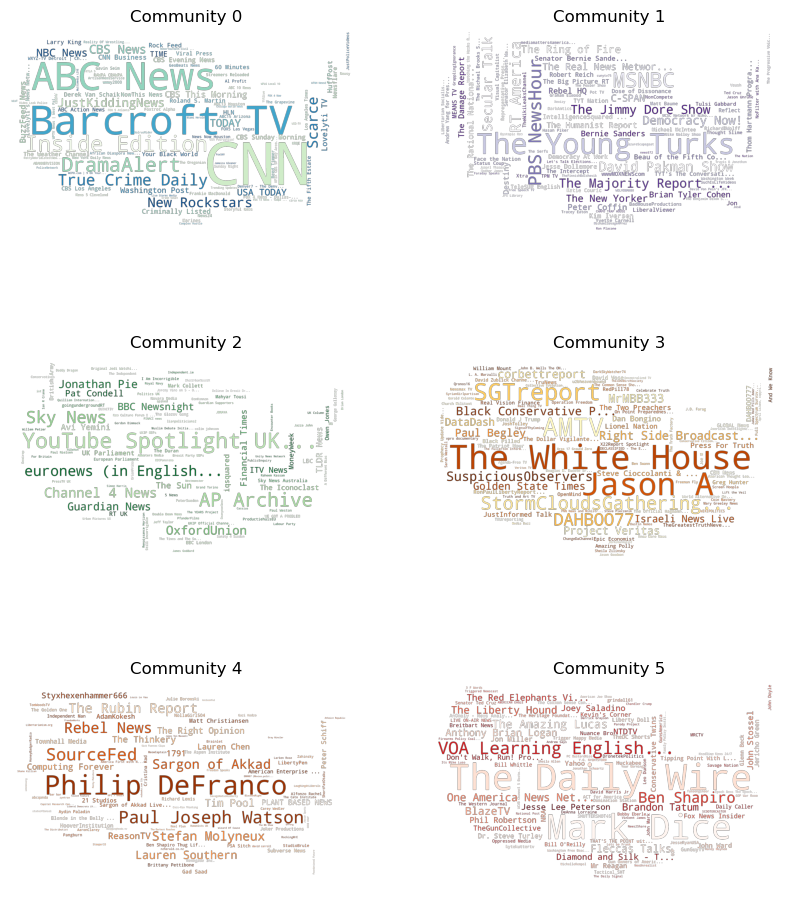

In [13]:
## Creating a subplot with the 6 communities

## Seting colors
colors=["GnBu","Purples","Greens","YlOrBr","Oranges","Reds"]

## Create subplot
fig, ax = plt.subplots(3,1, figsize=(10,12));

## Set transparency of the backgroud
fig.patch.set_alpha(0);

## Loop to apply the create_wordcloud function to each community
for i in range(0,6):
    plt.subplot(3, 2, i+1);
    ax=create_wordcloud(news_channels_com,i,colors[i]);

## Saving
#fig.savefig("../ste_website/ADAmantiumForgers/assets/img/wordclouds_merged_transparent.png",bbox_inches='tight',dpi=1200)